In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
from scipy import signal
from scipy.stats import norm
import wfdb 
from wfdb import processing
import obspy.signal.detrend
from obspy.signal.detrend import polynomial
from IPython.display import Video

In [2]:
path_f = 'fantasia-database-1.0.0/'
rec0_f = wfdb.rdrecord(path_f + 'f1o03')

path_mit = './mit-bih-normal-sinus-rhythm-database-1.0.0/'
rec0_mit = wfdb.rdrecord(path_mit + '16265')

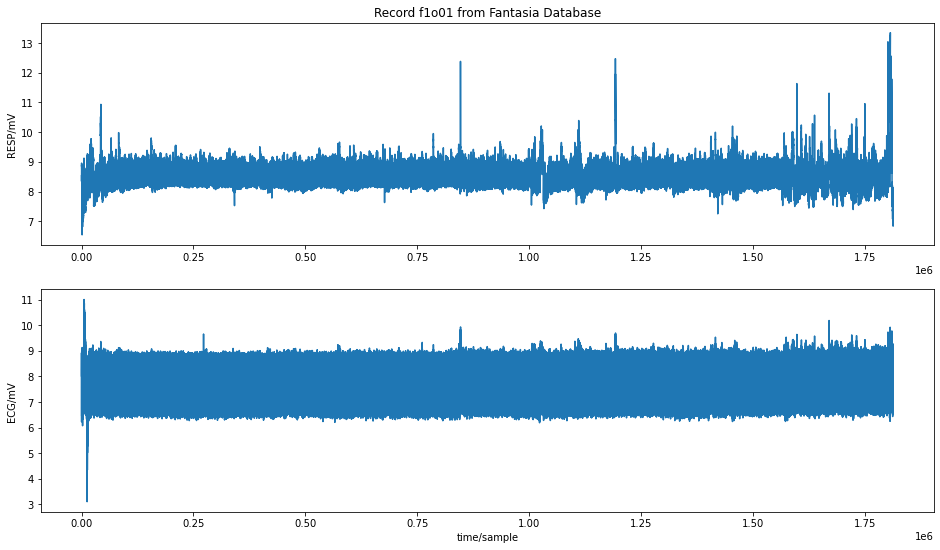

{'record_name': 'f1o03',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1813599,
 'base_time': None,
 'base_date': None,
 'comments': ['Age: 73 Sex: M'],
 'sig_name': ['RESP', 'ECG'],
 'p_signal': array([[ 8.532,  8.02 ],
        [ 8.508,  8.068],
        [ 8.504,  8.056],
        ..., 
        [ 6.896,  7.932],
        [ 6.876,  7.952],
        [ 6.84 ,  7.928]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['f1o03.dat', 'f1o03.dat'],
 'fmt': ['16', '16'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [2000.0, 2000.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [16, 16],
 'adc_zero': [0, 0],
 'init_value': [17064, 16040],
 'checksum': [16312, -29704],
 'block_size': [0, 0]}

In [3]:
wfdb.plot_wfdb(record=rec0_f, title='Record f1o01 from Fantasia Database', figsize=(16,9)) 
display(rec0_f.__dict__)

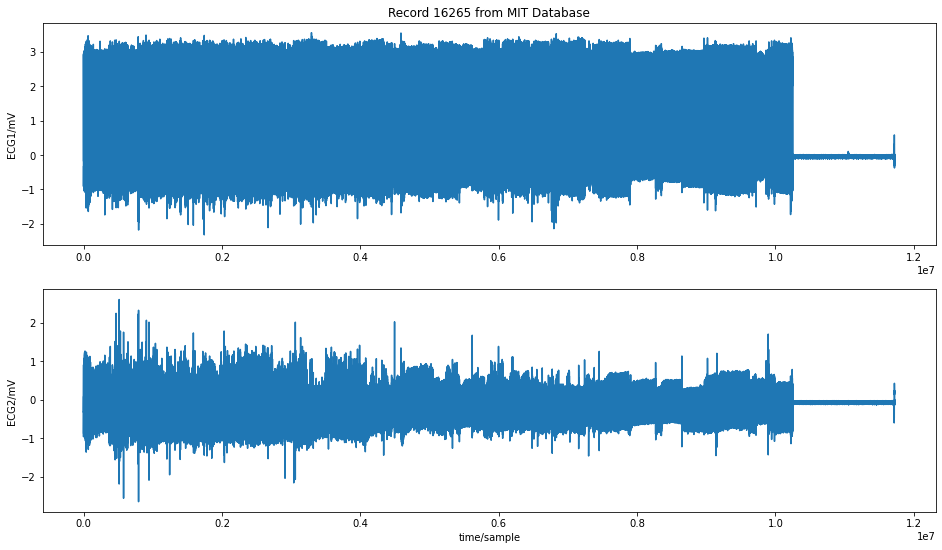

{'record_name': '16265',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 11730944,
 'base_time': datetime.time(8, 4),
 'base_date': None,
 'comments': ['32 M'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.165, -0.325],
        [-0.155, -0.325],
        [-0.195, -0.305],
        ..., 
        [-0.05 , -0.095],
        [-0.05 , -0.085],
        [-0.05 , -0.085]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['16265.dat', '16265.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-33, -65],
 'checksum': [15756, -21174],
 'block_size': [0, 0]}

In [4]:
wfdb.plot_wfdb(record=rec0_mit, title='Record 16265 from MIT Database', figsize=(16,9)) 
display(rec0_mit.__dict__)

In [5]:
# Use the XQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
#     hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs) # we don't need the heart rate
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
#     ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='cornflowerblue', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='red', label='Peak', markersize=12)
#     ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)')
#     ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y')
#     ax_right.tick_params('y', colors='m')
#     if saveto is not None:
#         plt.savefig(saveto, dpi=600)
    plt.show()
    return

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


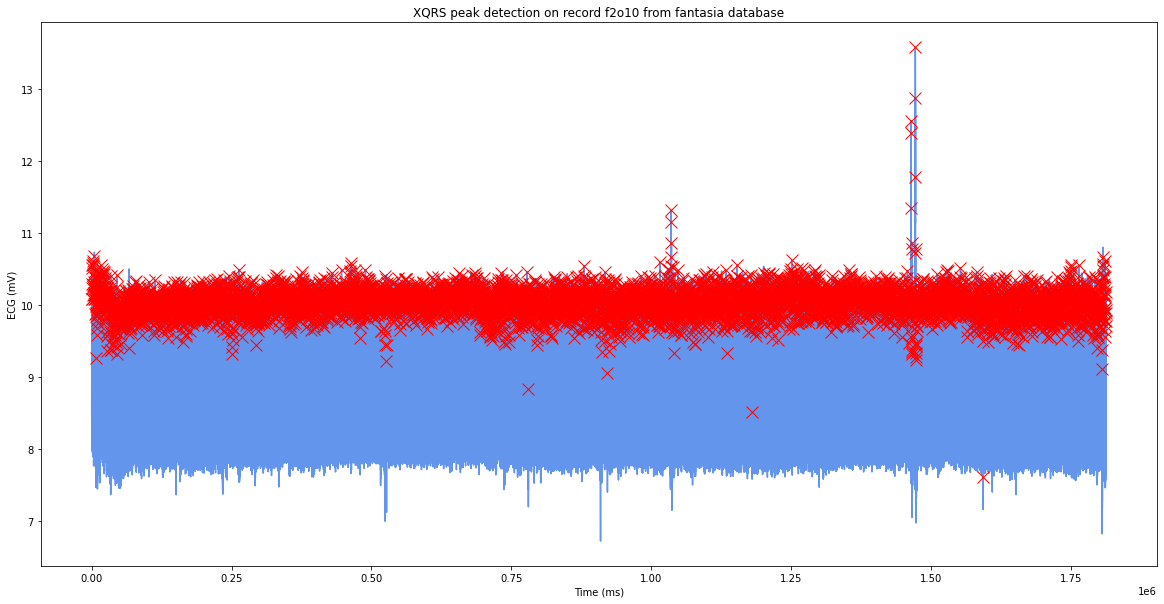

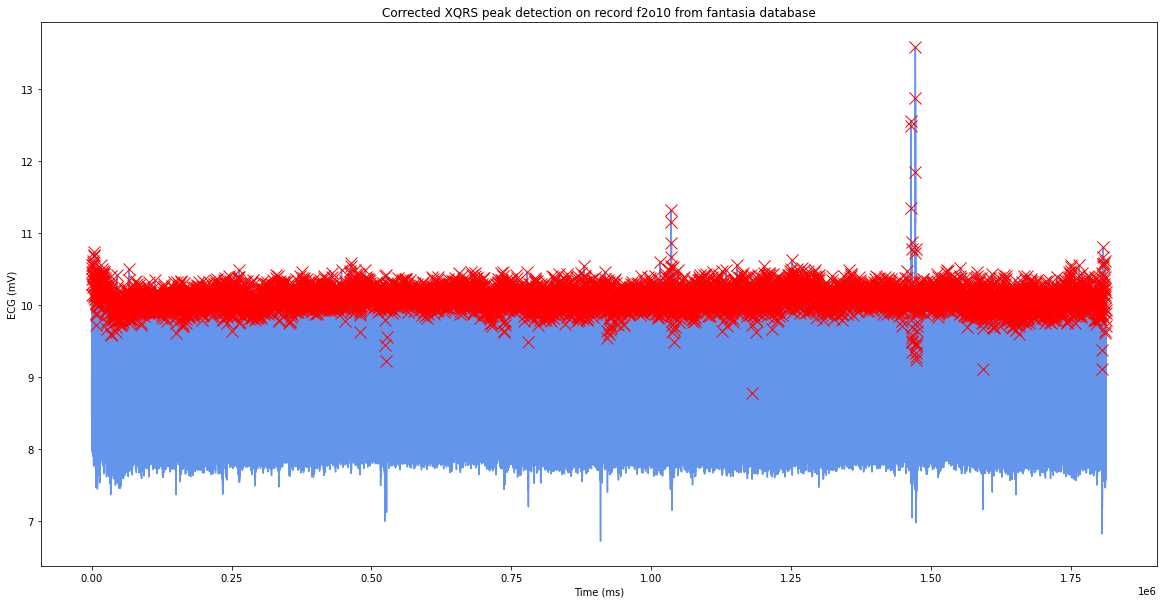

In [6]:
# Load the WFDB record; we only need the ECG data, that are in the second channel (channel number 1, starting from 0)
record = wfdb.rdrecord(path_f + 'f1o01', sampfrom=0, channels=[1])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.xqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="XQRS peak detection on record f2o10 from fantasia database")
    
# Correct the peaks shifting them to local maxima
min_bpm = 40
max_bpm = 200
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150, peak_dir='up')

# Display results
# print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected XQRS peak detection on record f2o10 from fantasia database")

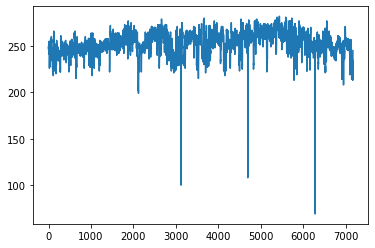

In [7]:
b_i = np.diff(sorted(corrected_peak_inds))
plt.plot(b_i)
plt.show()

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


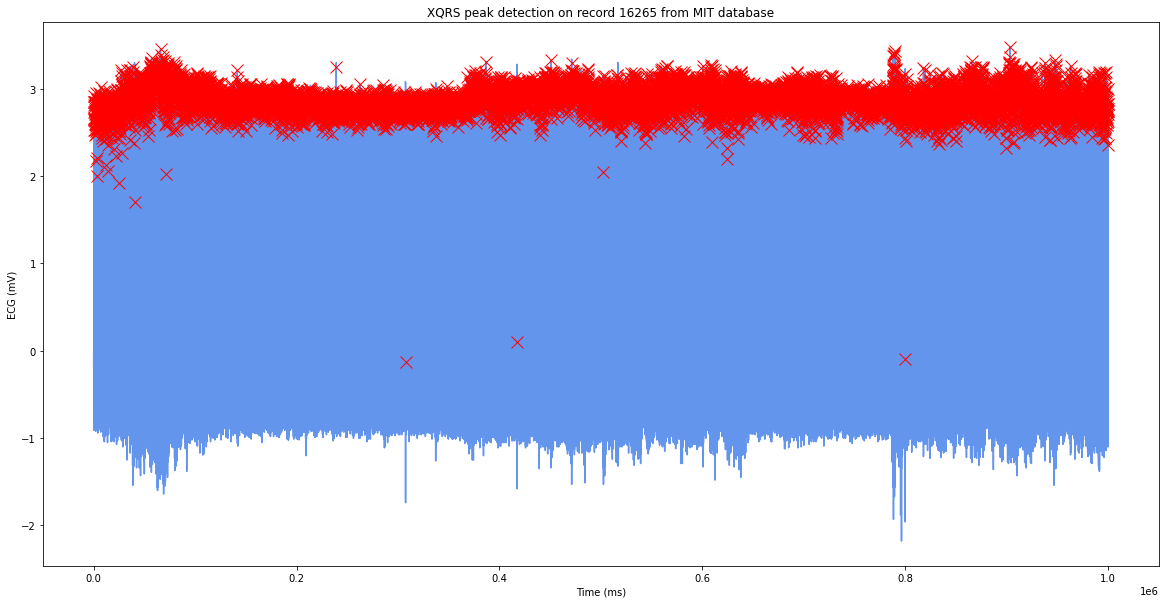

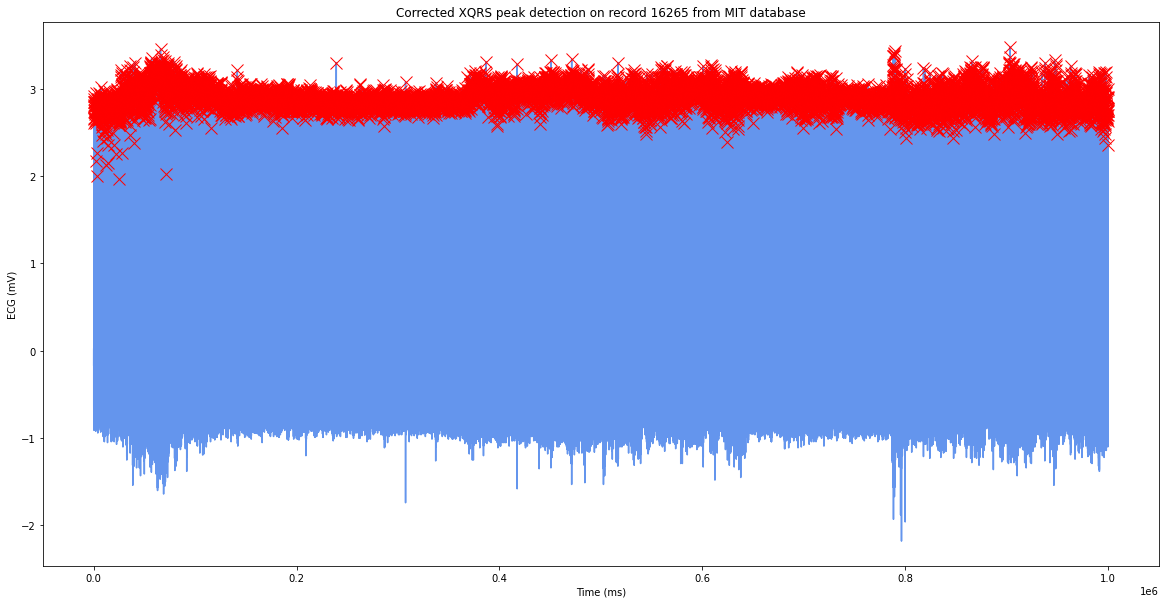

In [8]:
# Load the WFDB record; we only need the ECG data, that are in the second channel (channel number 1, starting from 0)
record = wfdb.rdrecord(path_mit + '16265', sampfrom=0, sampto=1000000, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.xqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="XQRS peak detection on record 16265 from MIT database")
    
# Correct the peaks shifting them to local maxima
min_bpm = 40
max_bpm = 200
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150, peak_dir='up')

# Display results
# print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected XQRS peak detection on record 16265 from MIT database")

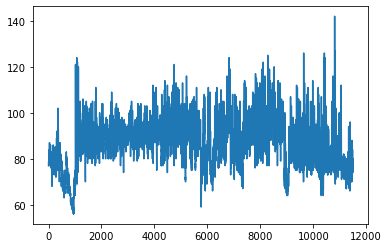

In [9]:
b_i = np.diff(sorted(corrected_peak_inds))
plt.plot(b_i)
plt.show()